In [2]:
import spacy
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

### Czyszczenie danych

In [14]:
df_raw = pd.read_csv(r'C:\Users\wilko\Desktop\Studia\Projekty swoje\Python\Machine learning\NLP-text-classification\data\descriptions\training_data.csv', header=0)
df = df_raw.copy()
df.head()

,Label,Opis
0,2,Do wynajęcia mieszkanie dwupokojowe z ogródkie...
1,2,"Wygodne, rozkładowe, częściowo umeblowane mies..."
2,2,Do wynajęcia mieszkanie 70m z tarasem o powier...
3,2,Na wynajem - jasne i przytulne mieszkanie dwup...
4,2,"[PL/EN] Piękne, stylowe i wysmakowan..."


In [15]:
df['Label'].value_counts()

0    268
1    250
2    249
Name: Label, dtype: int64

### Zapisanie opisów małymi literami

In [16]:
df['Opis'] = df['Opis'].str.lower()
df.head()

,Label,Opis
0,2,do wynajęcia mieszkanie dwupokojowe z ogródkie...
1,2,"wygodne, rozkładowe, częściowo umeblowane mies..."
2,2,do wynajęcia mieszkanie 70m z tarasem o powier...
3,2,na wynajem - jasne i przytulne mieszkanie dwup...
4,2,"[pl/en] piękne, stylowe i wysmakowan..."


### Usunięcie znaków specjalnych, interpunkcji oraz liczb

In [17]:
def remove_special_chars(text):
    if text is not None:
        cleaned_text = re.sub(r'[^\w\s]', '', text)  
        return cleaned_text
    else:
        return None

df['Opis'] = df['Opis'].str. replace('\d+', '')
df['Opis'] = df['Opis'].apply(remove_special_chars)

df.head()

C:\Users\wilko\AppData\Local\Temp\ipykernel_3404\1892002214.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Opis'] = df['Opis'].str. replace('\d+', '')


,Label,Opis
0,2,do wynajęcia mieszkanie dwupokojowe z ogródkie...
1,2,wygodne rozkładowe częściowo umeblowane mieszk...
2,2,do wynajęcia mieszkanie m z tarasem o powierzc...
3,2,na wynajem jasne i przytulne mieszkanie dwupo...
4,2,plen piękne stylowe i wysmakowane p...


### Steming i lemantyzacja

In [18]:
nlp = spacy.load('pl_core_news_md')

for opis in df['Opis']:
    doc = nlp(opis)
    przetworzony_opis = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    opis = przetworzony_opis


### Podział na dane treningowe i testowe

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df['Opis'], df['Label'], random_state=42, test_size=0.2, shuffle=True)


### Wektoryzacja danych tekstowych z wykorzystaniem macierzy TF-IDF

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=80)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

### Model maszyny wektorów nośnych

In [27]:
from sklearn.svm import SVC

svm_clf = SVC(C=5, kernel='linear', gamma='auto')
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)
print(svm_clf.score(X_test, y_test))

0.8051948051948052


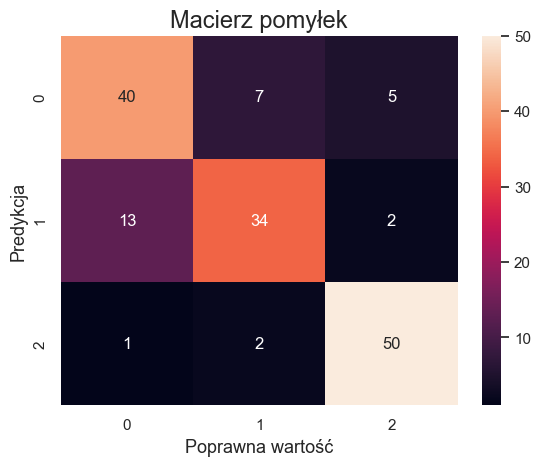

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2]
    )
plt.ylabel('Predykcja', fontsize=13)
plt.xlabel('Poprawna wartość', fontsize=13)
plt.title('Macierz pomyłek', fontsize=17)
plt.show()

### Model drzewa decyzyjnego

In [28]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion="gini", max_depth=3)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)
print(dt_clf.score(X_test, y_test))

0.8831168831168831


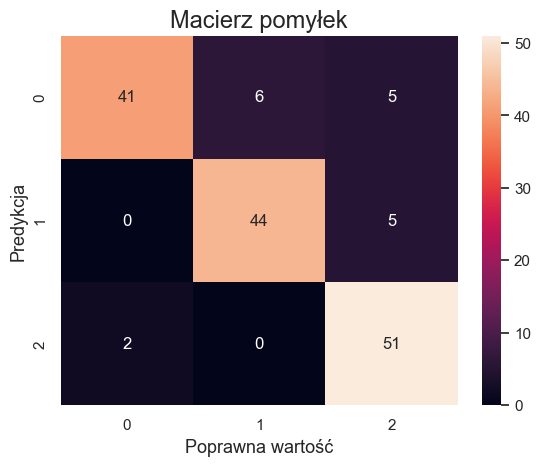

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2]
    )
plt.ylabel('Predykcja', fontsize=13)
plt.xlabel('Poprawna wartość', fontsize=13)
plt.title('Macierz pomyłek', fontsize=17)
plt.show()

### Model regresji logistycznej

In [30]:
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, y_train)

y_pred = logreg_clf.predict(X_test)
print(logreg_clf.score(X_test, y_test))

0.8051948051948052


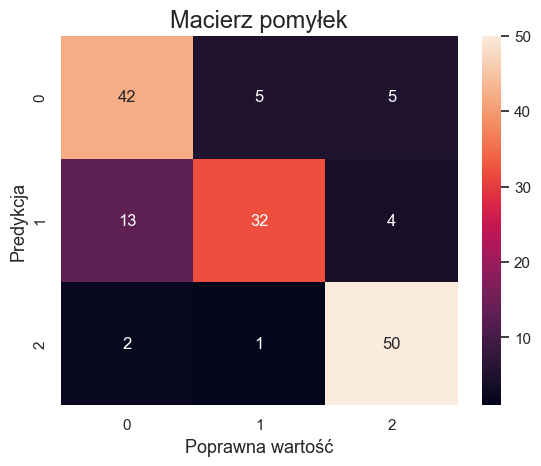

In [31]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2]
    )
plt.ylabel('Predykcja', fontsize=13)
plt.xlabel('Poprawna wartość', fontsize=13)
plt.title('Macierz pomyłek', fontsize=17)
plt.show()